In [115]:
# 导入基础依赖：math 数学函数、numpy 数值计算、matplotlib 可视化
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
# 定义一个二次函数 f(x) = 3*x**2 - 4*x + 5
def f(x):
  return 3*x**2 - 4*x + 5

In [117]:
# 计算 f(3.0) 并展示结果
f(3.0)

20.0

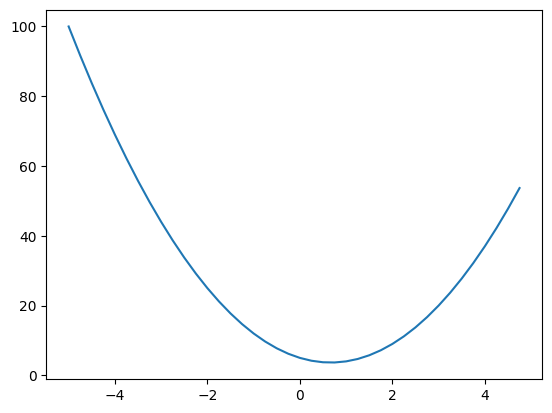

In [118]:
# 在区间 [-5,5] 上绘制 f(x) 曲线
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [119]:
# 用差分 (f(x+h)-f(x))/h 估算导数，验证 f'(2/3)
h = 0.000001
x = 0
(f(x + h) - f(x))/h

-3.99999700029241

In [120]:
# 定义标量 a,b,c 并计算 d = a*b + c
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [121]:
# 对 c 增量 h，再次计算 d，验证变化率 (d2-d1)/h
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c**2
b += h
d2 = a*b + c**2

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 94.0
d2 94.0002
slope 2.000000000066393


In [122]:
class Value:
    """
    Value 类是微型自动微分引擎的核心，用于表示计算图中的节点。
    每个 Value 对象保存数值 (data)、梯度 (grad)，并记录计算图的结构 (父节点和操作)。
    支持基本的数学运算 (+, *, tanh) 和反向传播 (backward)。
    """

    def __init__(self, data, _children=(), _op='', label=''):
        """
        初始化 Value 对象。

        参数:
            data (float): 节点的数值。
            _children (tuple): 父节点集合，表示该节点由哪些节点通过运算生成。
            _op (str): 生成该节点的运算符（如 '+'、'*'、'tanh'）。
            label (str): 节点的标签，便于调试和可视化。

        属性:
            self.data: 存储节点的数值。
            self.grad: 存储节点的梯度，初始为 0.0。
            self._backward: 定义该节点的反向传播函数，初始为空函数。
            self._prev: 存储父节点集合（set 类型）。
            self._op: 存储生成该节点的运算符。
            self.label: 存储节点的标签。
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        """
        定义 Value 对象的字符串表示形式，便于打印和调试。

        返回:
            str: 包含节点数据的字符串，如 "Value(data=2.0)"。
        """
        return f"Value(data={self.data})"

    def __add__(self, other):
        """
        重载加法运算符 (+)。赋予类对象加法运算能力
        """
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad  # 梯度累加：∂out/∂self = 1
            other.grad += 1.0 * out.grad  # 梯度累加：∂out/∂other = 1
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        重载乘法运算符 (*)。赋予类对象乘法运算能力
        """
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad  # 梯度累加：∂out/∂self = other.data
            other.grad += self.data * out.grad  # 梯度累加：∂out/∂other = self.data
        out._backward = _backward

        return out

    def tanh(self):
        """
        实现 tanh 激活函数。

        功能:
            创建一个新 Value 对象，表示 tanh(self.data)。
            同时定义新节点的反向传播函数，用于梯度计算。

        返回:
            Value: 表示 tanh 结果的新节点。

        实现逻辑:
            1. 计算 tanh(self.data)：
               - 使用公式：tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)。
            2. 创建新节点 out，记录父节点 (self,) 和运算符 'tanh'。
            3. 定义反向传播函数 _backward：
               - tanh 的导数：∂tanh(x)/∂x = 1 - tanh(x)^2。
               - 因此，self.grad += (1 - t^2) * out.grad，其中 t 是 tanh(self.data)。
        """
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)  # 计算 tanh(x)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad  # 梯度累加：∂out/∂self = 1 - tanh(x)^2
        out._backward = _backward

        return out

    def backward(self):
        """
        执行反向传播，计算计算图中所有节点的梯度。

        功能:
            从当前节点开始，沿着计算图反向传播，计算每个节点的梯度。

        实现逻辑:
            1. 使用拓扑排序构建节点序列：
               - 通过深度优先搜索 (DFS) 遍历计算图，确保子节点先于父节点处理。
               - 结果存储在 topo 列表中，顺序是从输入节点到输出节点。
            2. 初始化当前节点的梯度为 1.0（假设当前节点是损失函数）。
            3. 按拓扑序列的逆序调用每个节点的 _backward 函数，计算梯度。
        """
        topo = []
        visited = set()  # 

        def build_topo(v):
            """
            递归构建拓扑排序。

            参数:
                v (Value): 当前节点。

            逻辑:
                - 如果节点未被访问，标记为已访问。
                - 递归处理所有父节点。
                - 将当前节点添加到拓扑序列。
            """
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)  # 构建拓扑排序

        self.grad = 1.0  # 初始化输出节点的梯度为 1.0
        for node in reversed(topo):  # 按逆序遍历拓扑序列
            node._backward()  # 调用每个节点的反向传播函数


# 测试代码
a = Value(2.0, label='a') # 实例化名为a的Value类对象，数据为2.0
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'  # e 是一个新的 Value 对象，e._prev = {a, b}，e._op = '*'
d = e + c; d.label = 'd'  # d = e + c = -6.0 + 10.0 = 4.0
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'  # 实际上调用 d.__mul__(f)
L

Value(data=-8.0)

In [123]:
# 导入 graphviz 库，用于创建图形可视化
from graphviz import Digraph

def trace(root):
  """
  递归地遍历计算图，找出所有的节点 (Value 对象) 和边 (连接关系)。

  参数:
    root (Value): 计算图的根节点（通常是最终输出的 Value 对象）。

  返回:
    tuple: 包含两个集合，分别是节点集合和边集合。
           nodes (set): 计算图中所有唯一的 Value 对象。
           edges (set): 计算图中所有唯一的边，表示为 (父节点, 子节点) 的元组。
  """
  # 初始化用于存储节点和边的集合
  nodes, edges = set(), set()
  
  def build(v):
    """
    递归辅助函数，通过深度优先搜索 (DFS) 构建节点和边集合。

    参数:
      v (Value): 当前访问的 Value 节点。
    """
    # 如果当前节点 v 还没有被访问过
    if v not in nodes:
      # 将节点 v 添加到已访问节点集合中
      nodes.add(v)
      # 遍历当前节点 v 的所有父节点 (v._prev 存储了生成 v 的节点)
      for child in v._prev:
        # 添加一条从父节点 child 指向当前节点 v 的边
        edges.add((child, v))
        # 递归地对父节点 child 调用 build 函数，继续向上追溯
        build(child)
        
  # 从根节点 root 开始构建节点和边集合
  build(root)
  # 返回包含所有节点和边的元组
  return nodes, edges

def draw_dot(root):
  """
  使用 graphviz 创建并返回计算图的可视化对象 (Digraph)。

  参数:
    root (Value): 计算图的根节点。

  返回:
    Digraph: graphviz 的 Digraph 对象，可以用于渲染和显示计算图。
  """
  # 创建一个 Digraph 对象
  # format='svg': 指定输出格式为 SVG
  # graph_attr={'rankdir': 'LR'}: 设置图形属性，'LR' 表示从左到右绘制图形
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
  
  # 调用 trace 函数获取计算图的所有节点和边
  nodes, edges = trace(root)
  
  # 遍历所有节点，为每个节点在图中创建对应的图形元素
  for n in nodes:
    # 使用节点的内存地址作为唯一标识符 (uid)
    uid = str(id(n))
    # 为每个 Value 对象创建一个矩形节点 ('record' shape)
    # label 中包含节点的标签 (n.label)、数据 (n.data，保留4位小数) 和梯度 (n.grad，保留4位小数)
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.1f }" % (n.label, n.data, n.grad), shape='record')
    # 如果这个节点是由某个操作 (n._op) 产生的
    if n._op:
      # 为该操作创建一个单独的操作节点 (通常显示为椭圆形)
      # 操作节点的名称是在 Value 节点 uid 后附加操作符
      dot.node(name = uid + n._op, label = n._op)
      # 从操作节点连接一条边到它产生的 Value 节点
      dot.edge(uid + n._op, uid)

  # 遍历所有的边 (父节点 n1, 子节点 n2)
  for n1, n2 in edges:
    # 从父节点 n1 连接一条边到子节点 n2 对应的操作节点
    # 子节点 n2 的操作节点名称是 str(id(n2)) + n2._op
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  # 返回构建好的 Digraph 对象
  return dot

In [124]:
L.backward()

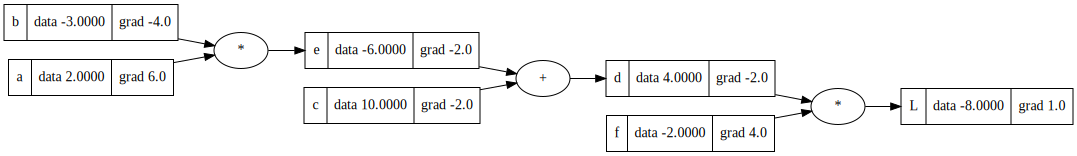

In [125]:
# 将变量 a,b,c,f 构造的计算图 L 可视化
draw_dot(L)

In [126]:
# 利用梯度更新 a,b,c,f，然后重新前向计算 L.data  0.01是学习率 前向过程
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-7.286496


In [150]:
# 定义一个函数 lol()，对比手写自动微分和数值微分结果
def lol():
  
  h = 0.00001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  c.data += h
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-1.9999999999242843


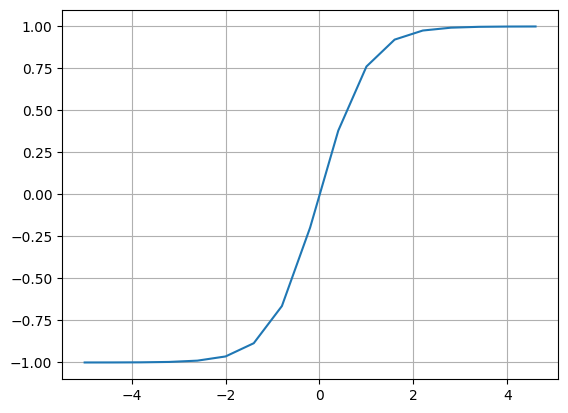

In [128]:
# 绘制 tanh 激活函数在 [-5,5] 区间的曲线
plt.plot(np.arange(-5,5,0.6), np.tanh(np.arange(-5,5,0.6))); plt.grid();

In [151]:
# 构造单个神经元：输入 x1,x2，权重 w1,w2，偏置 b，再计算 o = tanh(x1*w1 + x2*w2 + b)
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
print("n:", n)
print("o:", o)


n: Value(data=0.8813735870195432)
o: Value(data=0.7071067811865476)


![](D:/BaiduSyncdisk/DyVault/NoteImages/2025-04-23-21-33-11.png)

![](D:/BaiduSyncdisk/DyVault/NoteImages/2025-04-23-21-32-50.png)

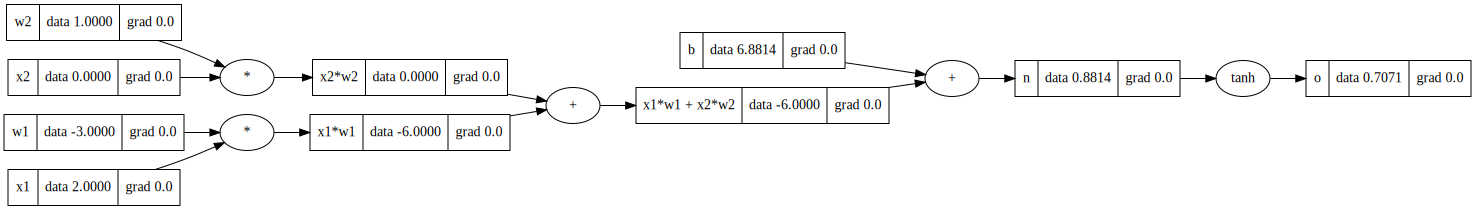

In [130]:
# 使用 Graphviz 可视化单神经元的前向计算图
draw_dot(o)

In [131]:
# 执行反向传播 生成并存储每个变量的grad属性
o.backward()

In [132]:
# 构建计算图的拓扑列表 topo，用于观察节点处理顺序
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [133]:
# 将输出 o 的梯度手动置为 1.0，准备手动演示 _backward 调用
o.grad = 1.0

In [134]:
# 手动执行 o 节点的反向传播函数
o._backward()

In [135]:
# 手动执行 n 节点的反向传播函数
n._backward()

In [136]:
# 手动执行 b 节点的反向传播函数（偏置 b 的梯度计算）
b._backward()

In [137]:
# 手动执行 x1*w1 + x2*w2 的反向传播
x1w1x2w2._backward()

In [138]:
# 手动分别调用 x2*w2 和 x1*w1 的反向传播
x2w2._backward()
x1w1._backward()

In [139]:
# 手动根据链式法则计算 x1 和 w1 的梯度
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [140]:
# 手动根据链式法则计算 x2 和 w2 的梯度
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [141]:
# 
x1w1.grad = 0.5
x2w2.grad = 0.5

In [142]:
# 注释漏洞：请手动补充
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [143]:
# 注释漏洞：请手动补充
n.grad = 0.5

In [144]:
# 注释漏洞：请手动补充
o.grad = 1.0

In [145]:
# 注释漏洞：请手动补充
1 - o.data**2

0.4999999999999999

In [146]:
# 注释漏洞：请手动补充
# o = tanh(n)
# do/dn = 1 - o**2

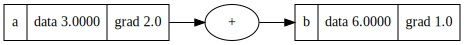

In [147]:
# 注释漏洞：请手动补充
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

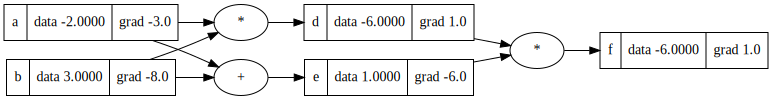

In [148]:
# 注释漏洞：请手动补充
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [149]:
# 注释漏洞：请手动补充
